# EM Cubes for Testing Response Matrix

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import sunpy.map
from astropy.visualization import ImageNormalize, LogStretch
from IPython.display import HTML
import xarray
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.wcs
import holoviews
from astropy.wcs.utils import pixel_to_pixel
from mocksipipeline.physics.dem.data_prep import DataPrep

In [3]:
response_matrix = xarray.open_dataarray('moxsi_response_matrix.nc')

In [4]:
response_matrix.log_temperature

<xarray.DataArray 'log_temperature' (log_temperature: 60)>
array([5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 , 5.45, 5.5 , 5.55,
       5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95, 6.  , 6.05, 6.1 , 6.15,
       6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55, 6.6 , 6.65, 6.7 , 6.75,
       6.8 , 6.85, 6.9 , 6.95, 7.  , 7.05, 7.1 , 7.15, 7.2 , 7.25, 7.3 , 7.35,
       7.4 , 7.45, 7.5 , 7.55, 7.6 , 7.65, 7.7 , 7.75, 7.8 , 7.85, 7.9 , 7.95])
Coordinates:
  * log_temperature  (log_temperature) float64 5.0 5.05 5.1 ... 7.85 7.9 7.95

## 1. Full-disk EM from observations

In [5]:
data_root = pathlib.Path('/Users/wtbarnes/Documents/presentations/sphere-workshop-2023-talk/data/observations/ar_2020-11-09T18:00:00.000')
aia_maps = sunpy.map.Map(list((data_root / 'AIA').glob('*.fits')))
xrt_maps = sunpy.map.Map(list((data_root / 'XRT').glob('*.fits')))

In [7]:
dp = DataPrep(
    map_list=aia_maps+[xrt_maps,],
    temperature_bin_edges=10**np.arange(5.5,7.6,0.1)*u.K,
)

In [8]:
em_full_disk = dp.run()

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipel

In [9]:
em_full_disk

NDCube
------
Dimensions: [ 20. 338. 338.] pix
Physical Types of Axes: [('phys.temperature',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: 1 / cm5
Data Type: float64

In [11]:
full_coord = sunpy.map.all_coordinates_from_map(em_full_disk[0])

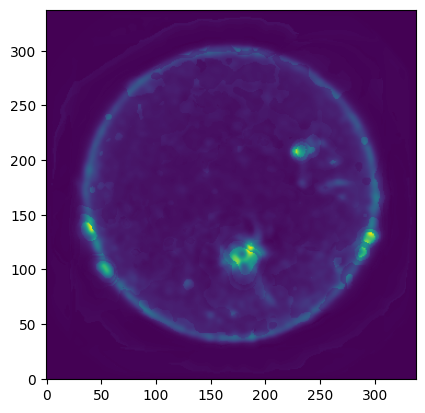

In [23]:
plt.imshow(em_full_disk.data.T.swapaxes(0,1)[...,0], origin='lower')

In [24]:
observed_dem_xarray = xarray.DataArray(
    em_full_disk.data.T.swapaxes(0,1),
    dims=['pixel_y', 'pixel_x', 'log_temperature'],
    coords={
        'log_temperature': np.log10(dp.temperature_bin_centers.to_value('K')),
        'hpc_longitude': (['pixel_y', 'pixel_x'], full_coord.Tx.to_value('arcsec')),
        'hpc_latitude': (['pixel_y', 'pixel_x'], full_coord.Ty.to_value('arcsec')),
    },
    attrs={
        'bunit': 'cm-5',
    },
    name='observed_full_disk_dem'
)

In [25]:
observed_dem_xarray_interp = observed_dem_xarray.interp(
    log_temperature=response_matrix.log_temperature,
    method='slinear',
    kwargs={'fill_value': 0.0,
            'bounds_error': False},
)

In [26]:
observed_dem_xarray_interp.to_netcdf('observed-dem.nc')

## 2. AR EM from simulations

In [2]:
m_dem_seq = sunpy.map.Map('/Users/wtbarnes/Documents/presentations/sphere-workshop-2023-talk/pipeline/data/p0.005/dem/m_*_t1500.fits',
                          sequence=True)

In [220]:
m_dem_seq.as_array().shape

(66, 54, 20)

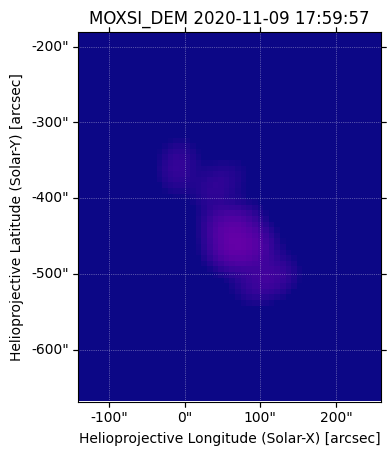

In [38]:
ani = m_dem_seq.plot(cmap='plasma',
                     norm=ImageNormalize(vmin=1e24, vmax=5e27, stretch=LogStretch()))

In [39]:
HTML(ani.to_jshtml())

In [20]:
temperature_bin_edges = np.unique(np.array(
    [m.meta['instrume'].split('_')[2].split('-') for m in m_dem_seq]
).astype(float).flatten())

In [23]:
temperature_bin_centers = (temperature_bin_edges[:-1] + temperature_bin_edges[1:])/2

reproject to full-disk WCS

In [61]:
full_disk_shape = response_matrix.shape[:1]+response_matrix.shape[:1]
full_disk_wcs = astropy.wcs.WCS(header=sunpy.map.make_fitswcs_header(
    full_disk_shape,
    SkyCoord(0,0,unit='arcsec',frame=m_dem_seq[0].coordinate_frame),
    reference_pixel=(np.array(full_disk_shape) - 1)/2*u.pix,
    rotation_matrix=m_dem_seq[0].rotation_matrix,
    scale=u.Quantity(m_dem_seq[0].scale),
))

In [234]:
pixel_to_pixel(m_dem_seq[0].wcs, full_disk_wcs, np.array([0,m_dem_seq[0].data.shape[1]-1]), np.array([0, m_dem_seq[0].data.shape[0]-1]))

[array([150.03890238, 203.03901903]), array([ 78.63639808, 143.63664462])]

In [71]:
reproject_kwargs = {'algorithm': 'adaptive',
                    'conserve_flux': True,
                    'kernel': 'Gaussian',
                    'boundary_mode': 'strict'}
m_dem_full = sunpy.map.Map([m.reproject_to(full_disk_wcs, **reproject_kwargs) for m in m_dem_seq],
                           sequence=True)

In [193]:
simulated_dem_array = m_dem_full.as_array()
simulated_dem_array = np.where(np.isnan(simulated_dem_array), 0, simulated_dem_array)

In [101]:
full_coord = sunpy.map.all_coordinates_from_map(m_dem_full[0])

In [131]:
simulated_dem_xarray = xarray.DataArray(
    simulated_dem_array,
    dims=['pixel_y', 'pixel_x', 'log_temperature'],
    coords={
        'log_temperature': temperature_bin_centers,
        'hpc_longitude': (['pixel_y', 'pixel_x'], full_coord.Tx.to_value('arcsec')),
        'hpc_latitude': (['pixel_y', 'pixel_x'], full_coord.Ty.to_value('arcsec')),
    },
    attrs={
        'bunit': 'cm-5',
        **m_dem_full[0].meta,
    },
    name='simulated_dem'
)

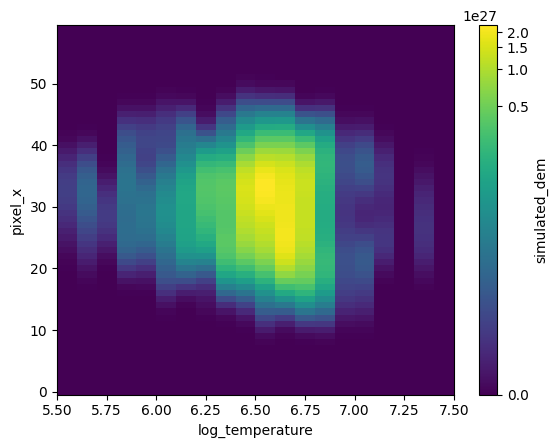

In [223]:
simulated_dem_xarray[100,150:210,:].plot(norm=ImageNormalize(stretch=LogStretch()))

(1e+23, 3e+27)

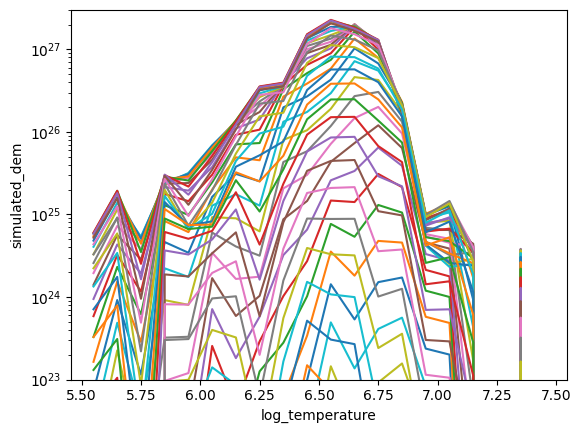

In [225]:
simulated_dem_xarray[100,...].plot.line(hue='pixel_x', yscale='log', add_legend=False);
plt.ylim(1e23,3e27)

Interpolate to same temperature bins as 

In [235]:
simulated_dem_xarray_interp = simulated_dem_xarray.interp(
    log_temperature=response_matrix.log_temperature,
    method='slinear',
    kwargs={'fill_value': 0.0,
            'bounds_error': False}
)

In [236]:
simulated_dem_xarray_interp.to_netcdf('simulated-dem.nc')

In [237]:
simulated_dem_xarray.to_netcdf('simulated-dem-no-interp.nc')

## Visualiztion with Holoviews/Xarray

Some visualization experiments

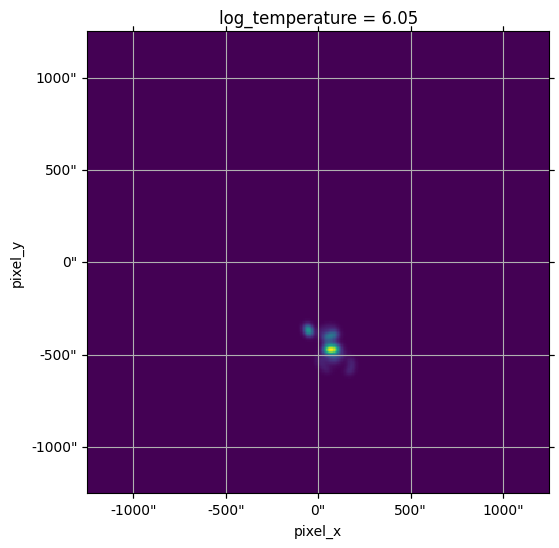

In [ ]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=m_dem_full[0].wcs)
#ax.set_global()
simulated_dem_xarray[...,5].plot.pcolormesh(
    ax=ax,
    transform=ax.get_transform('pixel'),
    x="pixel_x",
    y="pixel_y",
    add_colorbar=False,
)
ax.set_aspect(1)
#ax.coastlines()
#ax.set_ylim([0, 90]);

In [201]:
hv_ds = holoviews.Dataset(simulated_dem_xarray)

In [204]:
hv_dem = hv_ds.to(holoviews.QuadMesh, kdims=['hpc_longitude', 'hpc_latitude'], dynamic=False)
hv_dem_zoom = hv_dem[:,(-100):200,-600:(-200)].opts(
    fig_size=100,
    cmap='plasma',
    colorbar=True,
)

:HoloMap   [log_temperature]
   :QuadMesh   [hpc_longitude,hpc_latitude]   (simulated_dem)
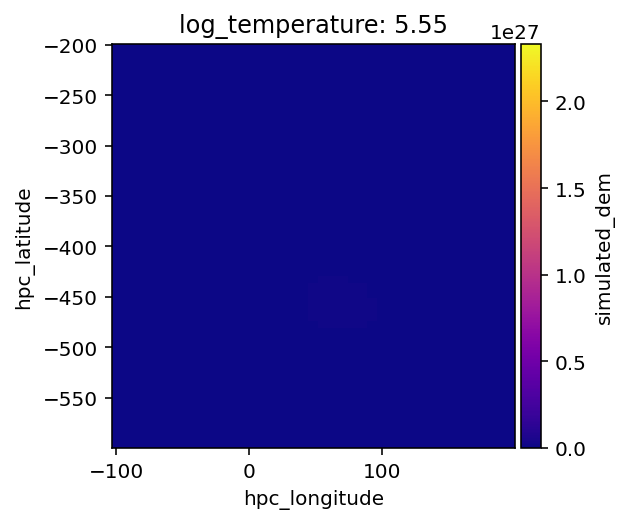
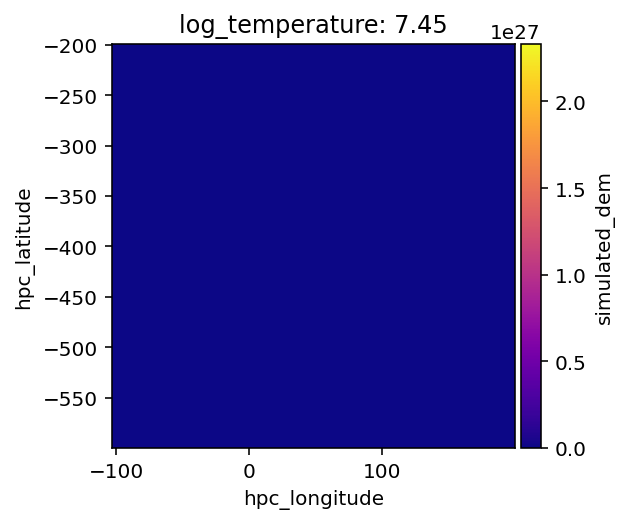
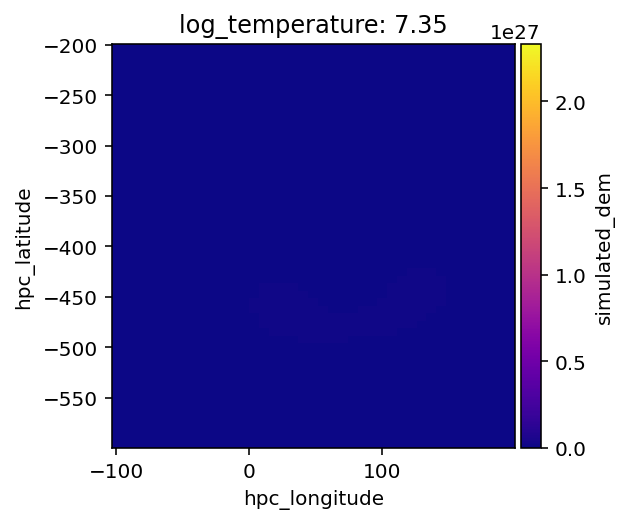
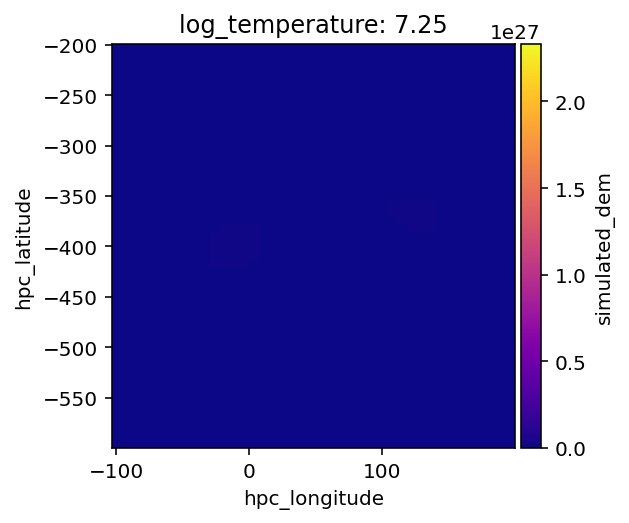
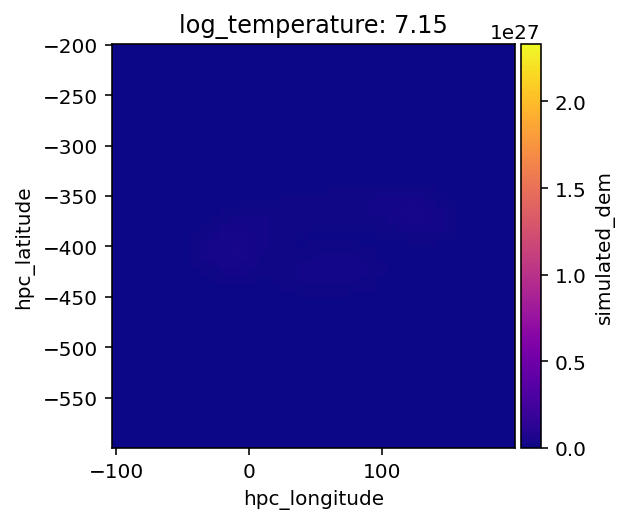
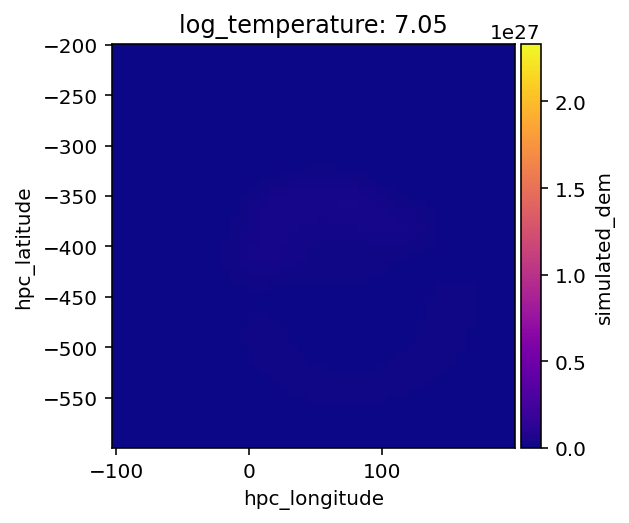
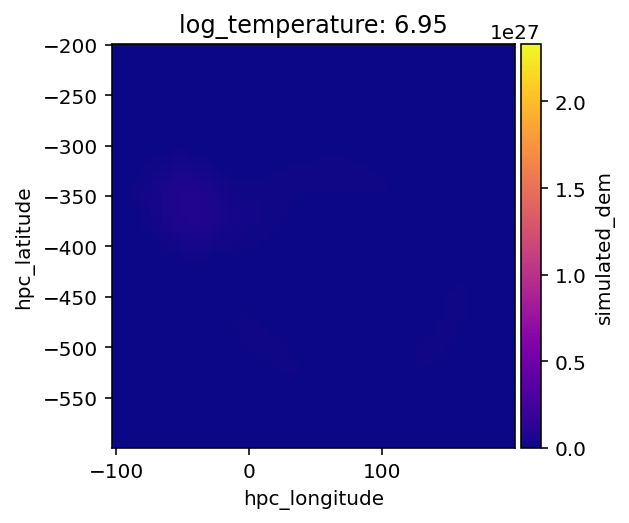
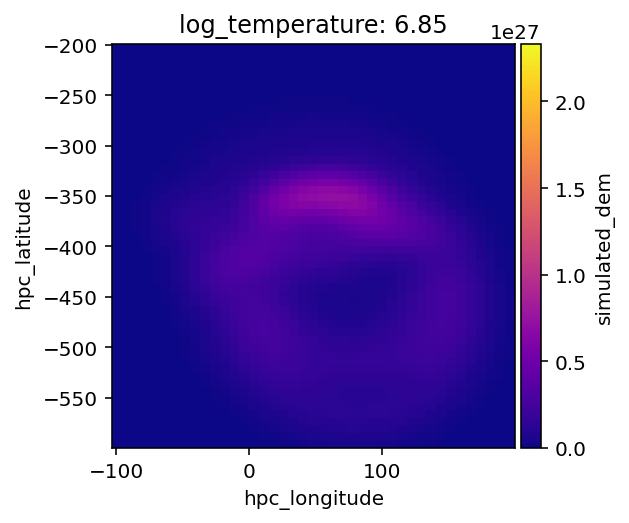
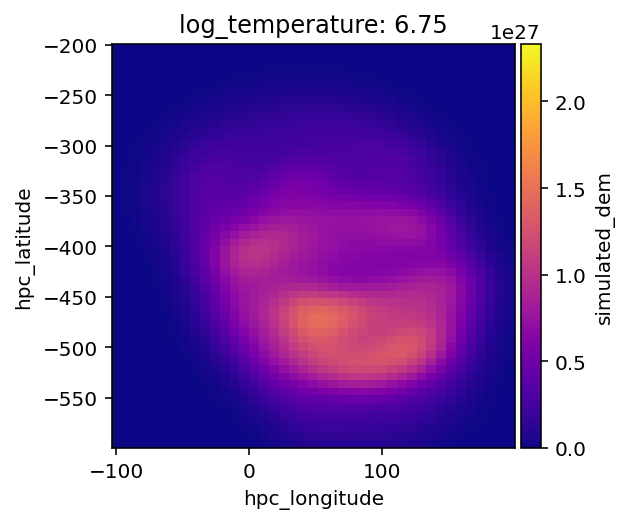
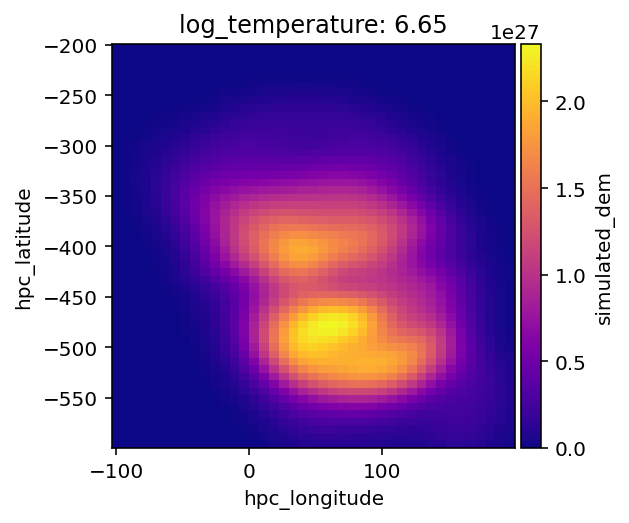
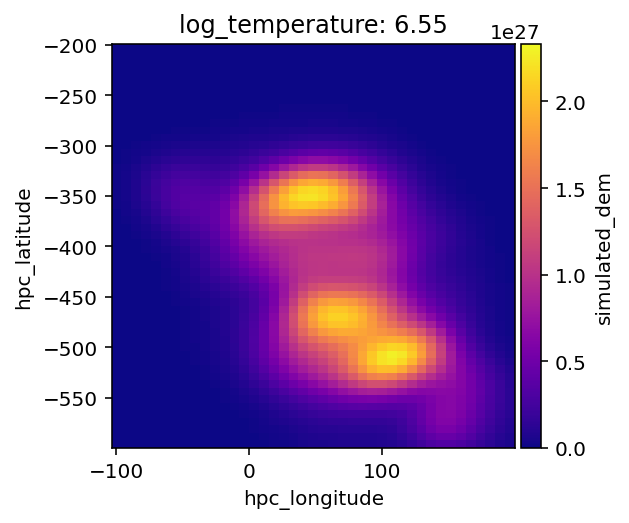
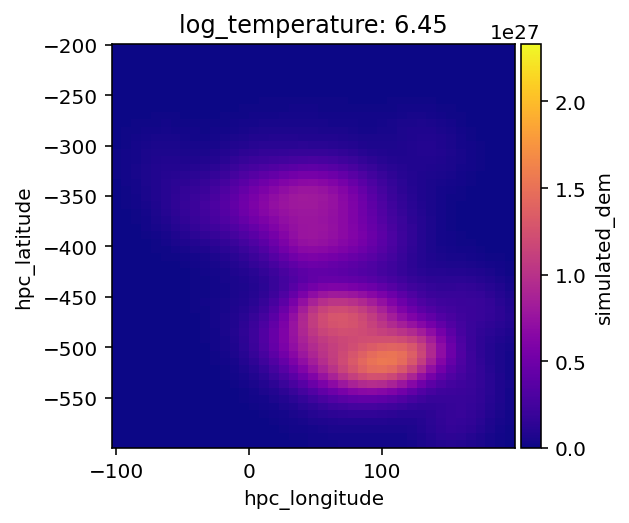
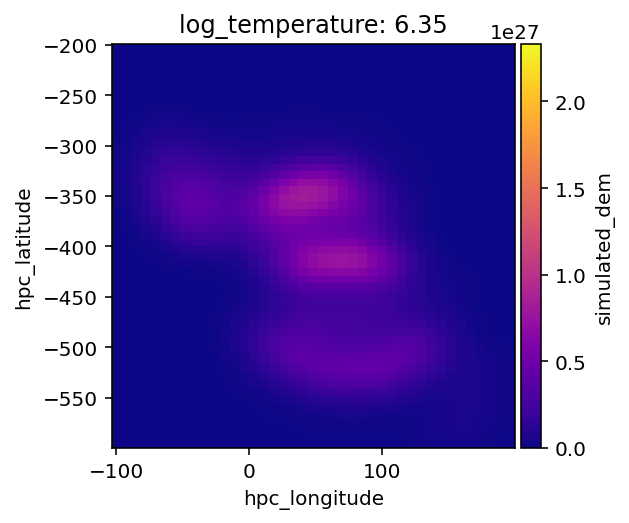
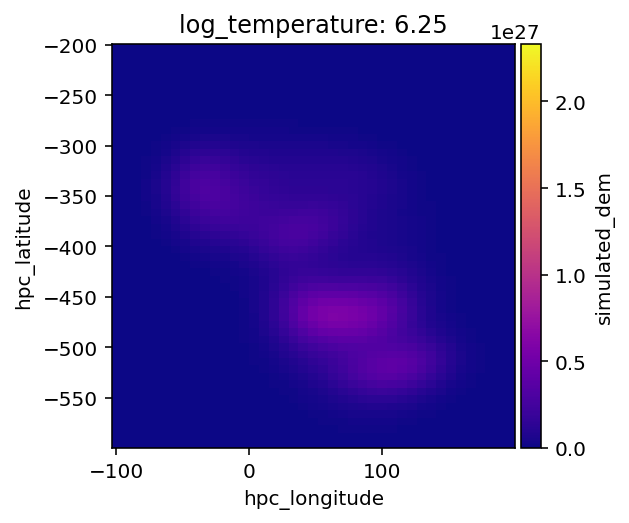
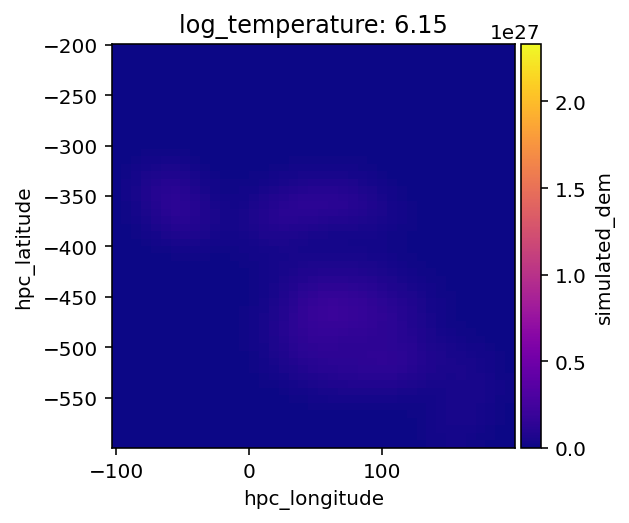
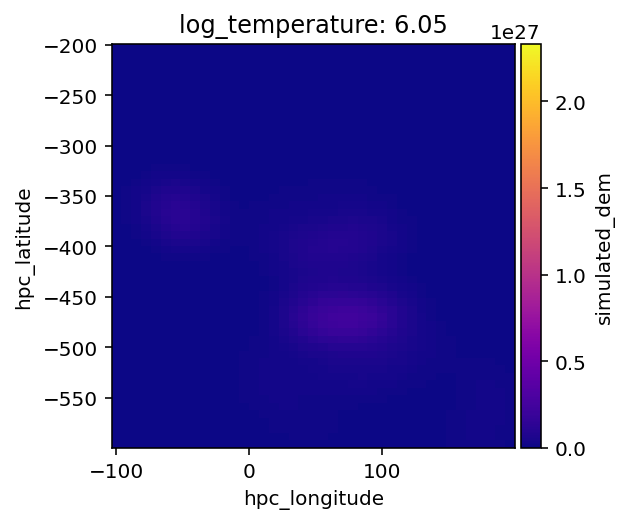
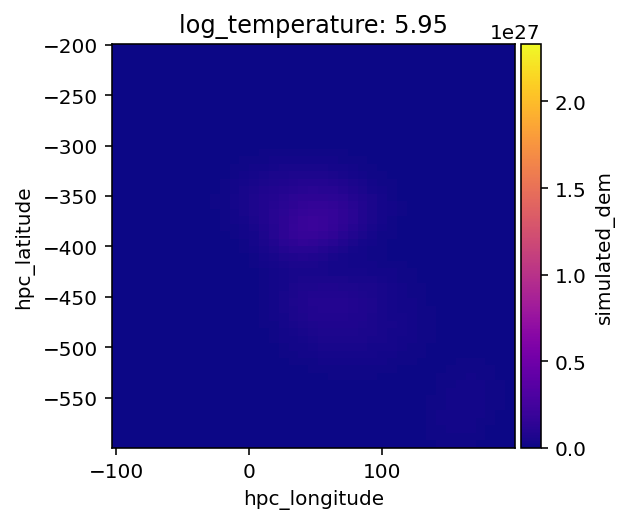
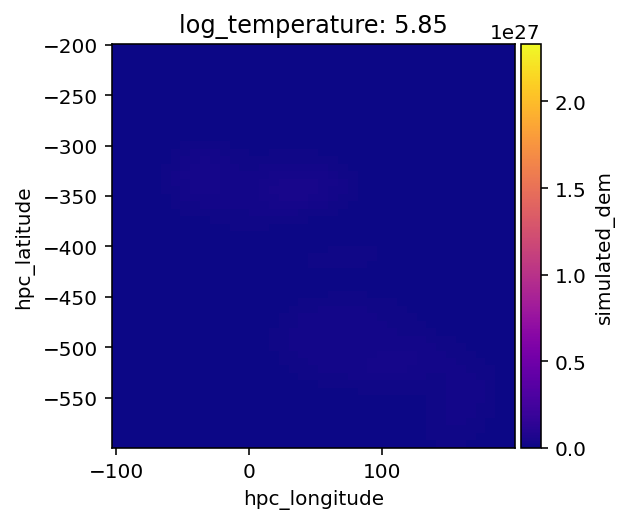
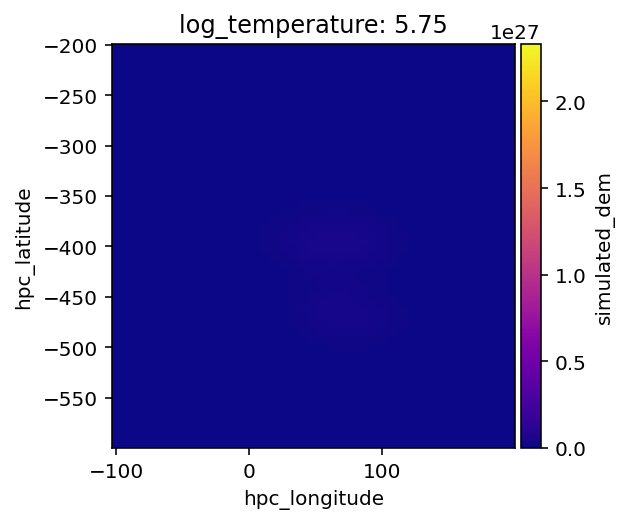
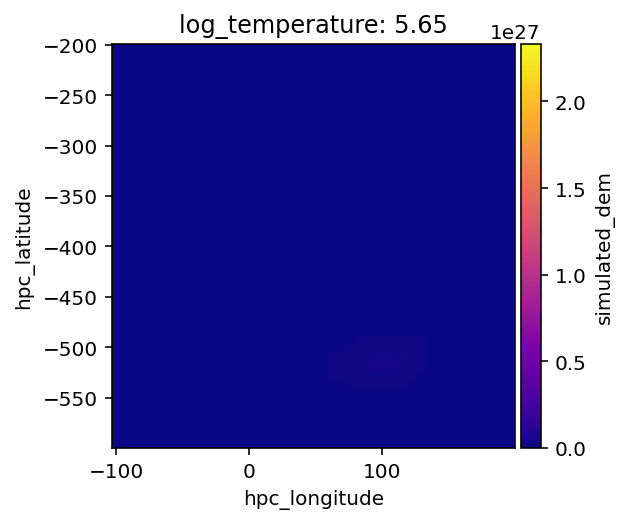
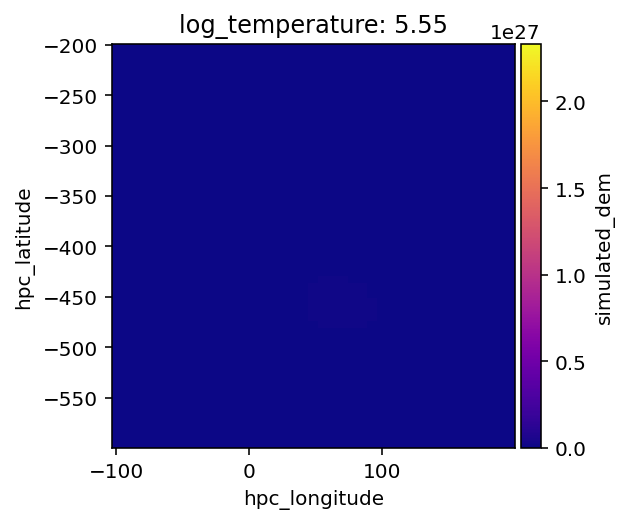

In [205]:
hv_dem_zoom

In [189]:
holoviews.save(hv_dem_zoom, 'holoviews-test.gif', fps=5)